In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets

%matplotlib inline
plt.rcParams['figure.figsize'] = (9.,6.)

## Fit the moons

In [2]:
def load_dataset():
  np.random.seed(1)

  # x.shape = (m,n) & y.shape = (m,)
  x, y = sklearn.datasets.make_moons(n_samples=300, noise=0.2)

  # Transpose shape & return: x.shape = (n,m) & y.shape = (1,m)
  return (x.T, y.reshape((1,y.shape[0])))

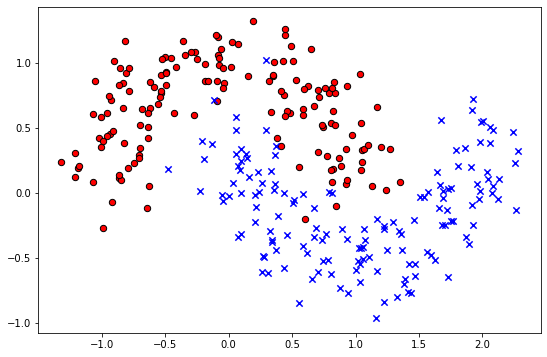

In [3]:
X_train, y_train = load_dataset()

plt.scatter(X_train[0, y_train[0,:] == 0], X_train[1, y_train[0,:] == 0], s=40, c='r', marker='o', cmap=plt.cm.Spectral, edgecolors='k')
plt.scatter(X_train[0, y_train[0,:] == 1], X_train[1, y_train[0,:] == 1], s=40, c='b', marker='x', cmap=plt.cm.Spectral, edgecolors='k')


## Initialize parameters

In [4]:
def initialize_params(layer_dims):
  
  np.random.seed(3)
  L = len(layer_dims)
  params = {}

  for l in range(1, L):
    params['W'+str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) # Xavier initialization
    params['b'+str(l)] = np.zeros((layer_dims[l],1))

    assert(params['W'+str(l)].shape == (layer_dims[l],layer_dims[l-1]))
    assert(params['b'+str(l)].shape == (layer_dims[l],1))

  return params

## Different activation functions

In [5]:
def sigmoid(z):
  return 1/(1+np.exp(-z))

def relu(z):
  return np.maximum(0,z)

## Forward Propagation

In [6]:
def forward_activation(A_prev, W, b, activation):
  Z = np.dot(W,A_prev) + b

  assert(Z.shape == (W.shape[0],A_prev.shape[1]))

  if activation == "sigmoid":
    A = sigmoid(Z)
  elif activation == "tanh":
    A = np.tanh(Z)
  elif activation == "relu":
    A = relu(Z)
  
  cache = (A_prev, W, b, Z)

  return A, cache

In [7]:
def forward_prop(X, params):
  L = len(params) // 2
  A = X
  caches = []

  for l in range(1,L):
    A_prev = A
    A, cache = forward_activation(A_prev, params["W"+str(l)], params["b"+str(l)], "tanh")
    caches.append(cache)

  A_L, cache = forward_activation(A, params["W"+str(L)], params["b"+str(L)], "sigmoid")
  caches.append(cache)

  return A_L, caches

## Calculate Loss

In [8]:
def calc_loss(A_L, y):
  m = y.shape[1]

  loss = (-1./m) * np.sum(y*np.log(A_L) + (1-y)*np.log(1-A_L))
  loss = np.squeeze(loss)
  
  assert(loss.shape == ())
  return loss

## Derivative of different activation functions
- Needed for back-prop

In [9]:
def sigmoid_back(z):
  a = sigmoid(z)
  assert(a.shape == z.shape)
  return a*(1-a)

def tanh_back(z):
  a = np.tanh(z)
  return (1-a**2)

def relu_back(z):
  a = (z>0).astype(int)
  return a

## Back Propagation

In [10]:
def back_activation(dA, cache, activation):
  m = dA.shape[1]
  A_prev, W, b, Z = cache

  if activation == "sigmoid":
    dZ = dA * sigmoid_back(Z)
  if activation == "tanh":
    dZ = dA * tanh_back(Z)
  if activation == "relu":
    dZ = dA * relu_back(Z)

  assert(dZ.shape == dA.shape)

  dW = np.dot(dZ, A_prev.T) / m
  db = np.sum(dZ, axis=1, keepdims=True) / m
  dA_prev = np.dot(W.T,dZ)

  assert(dW.shape == W.shape)
  assert(db.shape == b.shape)
  assert(dA_prev.shape == A_prev.shape)

  return dW, db, dA_prev

In [11]:
def back_prop(A_L, y, caches):
  m = A_L.shape[1]
  L = len(caches)
  grads = {}

  dA_L = - np.divide(y,A_L) + np.divide(1-y,1-A_L)
  #dZ_L = (1/m) * (A_L - y)
  
  assert(dA_L.shape == A_L.shape)

  cache = caches[L-1]
  grads["dW"+str(L)], grads["db"+str(L)], grads["dA"+str(L-1)] = back_activation(dA_L, cache, "sigmoid")

  for l in reversed(range(1,L)):
    cache = caches[l-1]
    grads["dW"+str(l)], grads["db"+str(l)], grads["dA"+str(l-1)] = back_activation(grads["dA"+str(l)], cache, "tanh")
  
  return grads

## Update parameters

In [12]:
def update_params(params, grads, learning_rate):
  L = len(params) // 2

  for l in range(L):
    params["W"+str(l+1)] = params["W"+str(l+1)] - learning_rate * grads["dW"+str(l+1)]
    params["b"+str(l+1)] = params["b"+str(l+1)] - learning_rate * grads["db"+str(l+1)]

  return params

## Model function to put together all the above components

In [13]:
def model(X, y, layer_dims, learning_rate=0.01, epochs=10000, print_loss=False):
  params = initialize_params(layer_dims)
  losses = []

  for t in range(epochs):
    
    A_L, caches = forward_prop(X, params)
    loss = calc_loss(A_L, y)
    grads = back_prop(A_L, y, caches)
    params = update_params(params, grads, learning_rate)

    if t%100 == 0 and print_loss:
      losses.append(loss)
      print("loss after iteration num " + str(t) + " : " + str(loss))
  
  return params

## Train your model

In [14]:
layer_dims = [2, 4, 1]
params = model(X_train, y_train, layer_dims, learning_rate=0.1, epochs=10000, print_loss=True)

loss after iteration num 0 : 0.7152438446331826
loss after iteration num 100 : 0.3457514117629067
loss after iteration num 200 : 0.31200977592848284
loss after iteration num 300 : 0.30389257929599045
loss after iteration num 400 : 0.3013237043444417
loss after iteration num 500 : 0.30005642415789946
loss after iteration num 600 : 0.29907097384456055
loss after iteration num 700 : 0.2981008551599098
loss after iteration num 800 : 0.2970751789200482
loss after iteration num 900 : 0.2959807723962469
loss after iteration num 1000 : 0.2948228082447801
loss after iteration num 1100 : 0.29361169257576797
loss after iteration num 1200 : 0.29235853791657945
loss after iteration num 1300 : 0.2910738177661694
loss after iteration num 1400 : 0.2897667577855482
loss after iteration num 1500 : 0.28844406600489503
loss after iteration num 1600 : 0.2871069864208292
loss after iteration num 1700 : 0.28574520006564125
loss after iteration num 1800 : 0.2843242773117667
loss after iteration num 1900 : 0.2

## Prediction and plotting the decision boundary

In [15]:
def predict(params, X):
    A2, cache = forward_prop(X, params)
    predictions = (A2>0.5) * 1
    
    return predictions

In [16]:
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - .3, X[0, :].max() + .3
    y_min, y_max = X[1, :].min() - .3, X[1, :].max() + .3
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.Spectral)
    plt.contour(xx, yy, Z, [0.5], linewidths=1.5, colors='white')
    plt.ylabel('x2')
    plt.xlabel('x1')
    #plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral, edgecolors='k')
    plt.scatter(X[0, y[0,:] == 0], X[1, y[0,:] == 0], s=40, c='r', marker='o', cmap=plt.cm.Spectral, edgecolors='k')
    plt.scatter(X[0, y[0,:] == 1], X[1, y[0,:] == 1], s=40, c='b', marker='x', cmap=plt.cm.Spectral, edgecolors='k')

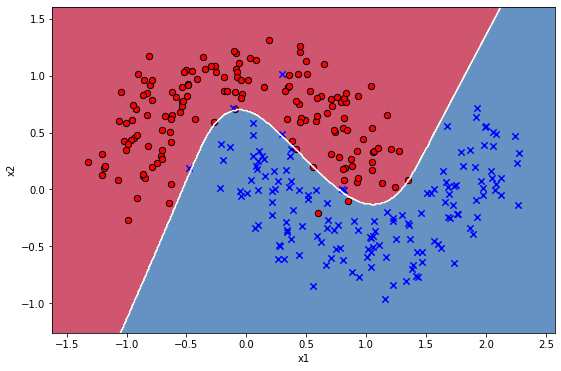

In [17]:
plot_decision_boundary(lambda x: predict(params, x.T), X_train, y_train)